# Extract text from multiple courses over all study boards over all years (2013-2024)

In [ ]:
#!pip install langdetect
#!pip install bs4

In [ ]:
# --- Libraries ---
import re, requests, time, html, unicodedata, json, logging, random, sys
from bs4 import BeautifulSoup, Tag
from urllib.parse import urljoin, urlparse
from langdetect import detect, DetectorFactory
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# --- Config ---
ARCHIVE_ROOT = f"https://kurser.ku.dk/archive/"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
URL_FILE = "all_course_urls.txt" # File to save discovered course URLs
SLEEP_COURSE = (0.2, 0.3)
SLEEP_BOARD  = (0.2, 0.3)

TARGET_YEARS = [
    "2013-2014", "2014-2015", "2015-2016", "2016-2017", "2017-2018",
    "2018-2019", "2019-2020", "2020-2021", "2021-2022", "2022-2023", "2023-2024"
]

# Splitter dictionary: for separating learning outcomes into sections and extracting knowledge/skills/competencies
SECTION_MAP = {
    "knowledge"   : ["knowledge", "viden"],
    "skills"      : ["skills", "færdigheder", "faerdigheder"],
    "competencies": ["competencies", "competence", "competences", "kompetencer"],
}

## ATTRIBUTE HEADINGS
# Coordinator headings dictionary: identifying on English and Danish pages
COORD_HEADINGS = [
    r'^course\s+coordinators$',      # English
    r'^course\s+responsibles$',      # English variant
    r'^kursusansvarlige$',           # Danish
]

# Credit headings dictionary: identifying on English and Danish pages
CREDIT_HEADINGS = [
    r'^credit$',      # English
    r'^point$',           # Danish
]

# Placement headings dictionary:  identifying on English and Danish pages
PLACEMENT_HEADINGS = [
    r'^placement$',      # English
    r'^placering$',           # Danish
]

# Contracting dept headings dictionary: identifying on English and Danish pages
CONTDEPT_HEADINGS = [
    r'^contracting\s+department$',      # English
    r'^udbydende\s+institut$',           # Danish
]



# Regex helpers (for managing inconsistent URL formatting)
YEAR_RE        = re.compile(r"^/?archive/(\d{4}-\d{4})/?$")
BOARD_RE_TPL   = r"^(?:/?archive/)?{year}/(?!course/)[^/]+/?$"
COURSE_RE_TPL  = r"^(?:/?archive/)?{year}/course/[A-Z0-9]+/?$"

# --- Functions ---
# make_abs: normalises URLs by removing extra whitespace and deduplicating 'archive/' prefix
def make_abs(href: str) -> str:
    href = href.lstrip('/')
    if href.startswith('archive/'):
        href = href[len('archive/'):]             # <- avoid double 'archive/' in URL
    return urljoin(ARCHIVE_ROOT, href)

# get_soup: fetches a URL and returns a BeautifulSoup object for parsing HTML content
def get_soup(url):
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        return BeautifulSoup(response.content, 'html.parser')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

# discover_studyboard_links: finds all study board links for a given year
def discover_studyboard_links(year_soup, year_slug):
    board_links = set()
    board_re = re.compile(BOARD_RE_TPL.format(year=re.escape(year_slug)))
    for a in year_soup.find_all("a", href=True):
        href = a["href"].strip()
        if board_re.match(href) and "/course/" not in href:
            board_links.add(make_abs(href))      # <— patched
    return sorted(board_links)

# discover_course_links_from_board: extracts course links from a study board page
def discover_course_links_from_board(board_soup, year_slug):
    course_links = set()
    course_re = re.compile(COURSE_RE_TPL.format(year=re.escape(year_slug)))
    for a in board_soup.find_all("a", href=True):
        href = a["href"].strip()
        if course_re.match(href):
            course_links.add(make_abs(href))     # <— patched
    return course_links

# discover_course_links_from_year: extracts course links (within study boards) for a given year
def discover_course_links_from_year(year_url):
    print(f"  Scraping year: {year_url}")
    year_soup = get_soup(year_url)
    if not year_soup:
        return set()

    year_slug  = year_url.rstrip("/").split("/")[-1]
    all_courses = set()

    # Discover all study board links for the year
    boards = discover_studyboard_links(year_soup, year_slug)
    print(f"    Found {len(boards)} study boards")

    # Loop through each board URL to uncover course links
    for bd_url in boards:
        bd_soup = get_soup(bd_url)
        if not bd_soup:
            continue
        courses = discover_course_links_from_board(bd_soup, year_slug)
        all_courses.update(courses)
        time.sleep(SLEEP_COURSE)

    # Console output and file writing
    print(f"    Found {len(all_courses)} course links for this year.")
    with open(URL_FILE, 'w', encoding='utf-8') as f:
                for course_url in sorted(list(all_courses)):
                    f.write(course_url + "\n")
                print(f"All URLs saved to {URL_FILE}")
    return all_courses

# clean: normalises text by removing extra whitespace
def clean(text: str | None) -> str | None:
    if not text:
        return text
    return re.sub(r'\s+', ' ', text).strip()

# deaccent: removes accents from characters in a string
def deaccent(txt: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFKD', txt)
        if not unicodedata.combining(c)
    )

# normalise: lower-cases, strips leading bullets/dashes/spaces and trailing punctuation - flag as duplicate
def normalise(txt: str) -> str:
    txt = re.sub(r'^[\s•\-–—]+', '', txt, flags=re.UNICODE)   # leading marks
    txt = txt.lower()
    txt = re.sub(r'[:—\-\s]+$', '', txt)                      # trailing ':'/dash
    return txt.strip()

# parse_email_from_onclick: decodes old multi-arg pattern for email addresses (not functional) - returns raw hex blob instead
def parse_email_from_onclick(onclick_attr):
    if not onclick_attr:
        return None

    # ❶ Old multi-argument variant
    parts = re.findall(r"'([^']+)'", onclick_attr)
    if len(parts) >= 2:
        if "." not in parts[0]:                       # heuristic: looks like a name, not a hex blob
            local  = parts[0]
            domain = '.'.join(parts[1:])
            domain = domain.replace('.', '@', 1)      # first dot → '@'
            return f"{local}@{domain}"

    # ❷ New single-blob variant -> just return it raw for now
    blob_match = re.search(r"'([^']+)'", onclick_attr)
    if blob_match:
        return f"obfuscated:{blob_match.group(1)}"    # keep track for later decoding

    return None

# split_learning_outcomes: robust splitter for learning outcomes - Returns dict with keys 'knowledge' / 'skills' / 'competencies' (En, Da), accepts headings with bullets, dashes, accents, and regex '?'
def split_learning_outcomes(raw_text: str) -> dict[str, str]:
    # build a normalised lookup
    variant2key = {normalise(v): k for k, vs in SECTION_MAP.items() for v in vs}

    # scan the text line by line
    lines = raw_text.splitlines()
    current = None
    buckets = {k: [] for k in SECTION_MAP}

    for line in lines:
        txt_norm = normalise(line)
        matched_key = None
        for variant_norm, key_name in variant2key.items():
        # a heading counts if the normalised variant appears
        # either as a standalone word OR as "<variant>:" in the line
            if f"{variant_norm}:" in txt_norm or variant_norm in txt_norm.split():
                matched_key = key_name
                break
        if matched_key:
            current = matched_key
            continue
        if current:
            buckets[current].append(line.strip())

    # collapse whitespace & return
    clean_bucket = lambda lst: re.sub(r"\s+", " ", " ".join(lst)).strip() or None
    return {k: clean_bucket(v) for k, v in buckets.items()}

# dedup: removes duplicate entries from a list while preserving order - for extract_course_data
def dedup(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

# extract_course_data: extracts all required data points from a course page soup object
def extract_course_data(soup, url):
    data = {
        'year': None, 'course_code': None, 'course_title': None, 'credit': None, 'placement': None, 'contracting_department': None,
        'coordinators': None, 'coordinator_emails': None, 'content': None,
        'learning_outcomes': None, 'knowledge': None, 'skills': None,
        'competencies': None, 'language': None, 'level': None, 'web_lang': None
    }

    # 1. Year and Course Code from URL
    parts = urlparse(url).path.strip('/').split('/')
    # URL pattern: ['archive', '2023-2024', 'course', 'LOJK10281U']
    if len(parts) >= 4:
        data['year'] = parts[1]          # '2023-2024'
        data['course_code'] = parts[-1]  # 'LOJK10281U'

    # 2. Course title (keeps "Cancelled" for reference, removes duplicate code)
    h1 = soup.find('h1', class_='courseTitle')
    if h1:
        status_span = h1.find('span')
        status_text = ""
        if status_span:
            status_text = status_span.get_text(strip=True)
            status_span.extract()  # drop from <h1> so it isn’t duplicated
        raw = html.unescape(h1.get_text(" ", strip=True)).replace('\xa0', ' ')
        raw = re.sub(r'\s+', ' ', raw).strip()          # <-- NEW: collapse CR/LF/Tabs to one space
        # raw now like: "LOJK10281U Animals in Society"

        tokens = raw.split(maxsplit=1)
        if tokens:
            # tokens[0] is the code – discard; tokens[1] (if present) is the human title
            title_core = tokens[1] if len(tokens) > 1 else ""
            data['course_title'] = f"{status_text} {title_core}".strip() if status_text else title_core

    # 3. Coordinators and Emails
        names, mails = [], []

    # find the first <h5> whose text matches any accepted heading
    coord_h5 = None
    for pat in COORD_HEADINGS:
        coord_h5 = soup.find('h5', string=re.compile(pat, re.I))
        if coord_h5:
            break                       # stop at the first match

    if coord_h5:
        # the UL that follows the <h5>
        ul = coord_h5.find_next('ul', class_='list-unstyled')
        if ul:
            for li in ul.find_all('li', recursive=False):
                # ---- e-mail (span with onclick="mail(...)") ----
                span = li.find(attrs={'onclick': re.compile(r"mail\(")})
                if span:
                    email = parse_email_from_onclick(span.get('onclick'))
                    if email:
                        mails.append(email)
                    span.extract()       # remove span so name text stays clean

                # ---- coordinator name (remaining li text) ----
                name_text = re.sub(r'\s+', ' ', li.get_text(" ", strip=True))
                if name_text:
                    names.append(name_text)

    data['coordinators']        = dedup(names)  or None
    data['coordinator_emails']  = dedup(mails)  or None

    # 3.5. Credits, Placement, and Contracting Department
    credits, placement, contract_dept = [], [], []

    # find the first <h5> whose text matches any accepted heading
    coord_h5 = None
    for pat in COORD_HEADINGS:
        coord_h5 = soup.find('h5', string=re.compile(pat, re.I))
        if coord_h5:
            break                       # stop at the first match

    if coord_h5:
        # the UL that follows the <h5>
        ul = coord_h5.find_next('ul', class_='list-unstyled')
        if ul:
            for li in ul.find_all('li', recursive=False):
                # ---- e-mail (span with onclick="mail(...)") ----
                span = li.find(attrs={'onclick': re.compile(r"mail\(")})
                if span:
                    email = parse_email_from_onclick(span.get('onclick'))
                    if email:
                        mails.append(email)
                    span.extract()       # remove span so name text stays clean

                # ---- coordinator name (remaining li text) ----
                name_text = re.sub(r'\s+', ' ', li.get_text(" ", strip=True))
                if name_text:
                    names.append(name_text)

    data['credits']        = dedup(credits)  or None
    data['placement']  = dedup(placement)  or None
    data['contract_dept']  = dedup(contract_dept)  or None

    # 4. Content
    content_div = soup.find('div', class_='course-item course-content')
    if content_div:
        data['content'] = content_div.get_text(separator=' ', strip=True)

    # 5. Learning Outcomes (main container)
    learning_div = soup.find('div', class_='course-description')
    if learning_div:
        full_txt = learning_div.get_text("\n", strip=True)
        data['learning_outcomes'] = clean(full_txt)
        sect = split_learning_outcomes(full_txt)
        data.update(sect)          # merges knowledge / skills / competencies

    # 7. Language and Level
    for dl in soup.find_all('dl', class_=re.compile(r'dl[-_]horizontal')):
        for dt in dl.find_all('dt'):
            key_raw = dt.get_text(strip=True).lower()
            dd = dt.find_next_sibling('dd')
            if not dd:
                continue
            val = clean(dd.get_text(" ", strip=True))
            if not val:
                continue

            # --- multilingual matching ---
            if any(tok in key_raw for tok in ('language', 'sprog', 'undervisningssprog')) \
            and not data['language']:
                data['language'] = val

            elif any(tok in key_raw for tok in ('level', 'niveau')) \
                and not data['level']:
                data['level'] = val
            # ---

        if data['language'] and data['level']:
            break

    # 8. Clean up text output
    for k in ('content', 'learning_outcomes', 'knowledge',
          'skills', 'competencies'):
        data[k] = clean(data[k])

    # 9. Detect page language (content-based)
    sample_text = (
        data['content']
        or data['learning_outcomes']
        or data['course_title']
        or ''
    )

    # is_missing: represents '0' or blank values for auditing the data by counting missing fields
    def is_missing(value):
        if value is None: return True
        if isinstance(value, str): return value.strip() == ""
        if isinstance(value, (list, tuple, set)): return len(value) == 0
        return False

    try:
        lang_code = detect(sample_text) if sample_text else 'unknown'
    except Exception:
        lang_code = 'unknown'
    data['web_lang'] = lang_code              # e.g. 'en', 'da', 'unknown'
    return data

# Main Script (takes long time)

In [ ]:
# --- Looping scraper over all defined years ---
for TARGET_YEAR in TARGET_YEARS:
    YEAR_URL    = f"{ARCHIVE_ROOT}{TARGET_YEAR}"
    OUT_FILE    = Path(f"courses_{TARGET_YEAR}_all_boards.json")
    LOG_FILE    = Path(f"scrape_{TARGET_YEAR}.log")

    # Produce log file to capture console output for each year
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[logging.FileHandler(LOG_FILE, encoding="utf-8"),
                  logging.StreamHandler(sys.stdout)],
        force=True,
    )
    log = logging.getLogger(__name__)
    log.info("=== Scrape start %s ===", TARGET_YEAR)

    # Define URL prefixes for board and course links
    PREFIX_BOARD  = f"{ARCHIVE_ROOT}{TARGET_YEAR}/"
    PREFIX_COURSE = f"{ARCHIVE_ROOT}{TARGET_YEAR}/course/"

    # Function to normalise board URLs in TARGET_YEAR
    fix_board  = lambda u: u if "/archive/" in u else u.replace(f"/{TARGET_YEAR}",
                           f"/archive/{TARGET_YEAR}", 1).replace("//", "/").replace(":/", "://")

    # fix_course: normalises course URLs in TARGET_YEAR
    def fix_course(u: str) -> str:
        if "/archive/" not in u:
            u = u.replace(f"/{TARGET_YEAR}/course/", f"/archive/{TARGET_YEAR}/course/", 1)
        if not u.startswith("http"):
            u = PREFIX_COURSE + u.lstrip("/").split("course/")[-1]
        return u

    # Fetch the year page soup
    year_soup = get_soup(YEAR_URL) or sys.exit("❌  Year page failed – aborting")
    board_urls = [fix_board(u) for u in discover_studyboard_links(year_soup, TARGET_YEAR)]
    if not board_urls:
        sys.exit("❌  No study boards found – HTML structure changed?")
    log.info("Discovered %d boards", len(board_urls))

    # Initialise lists for records and failures when extracting web pages
    records, failed_courses, failed_boards = [], [], []
    seen_courses = set()

    # --- Scrape loop within a given TARGET_YEAR ---
    for bi, board in enumerate(board_urls, 1):
        log.info("[%d/%d] %s", bi, len(board_urls), board)

        # Fetch the board page soup (beautifulsoup object)
        board_soup = get_soup(board)

        # Error handling if no board returned
        if not board_soup:
            log.warning("Board fetch failed – skipped")
            failed_boards.append(board); time.sleep(random.uniform(*SLEEP_BOARD)); continue

        # Within each board, discover course links (sorted by course code)
        for ci, course in enumerate(sorted(discover_course_links_from_board(board_soup, TARGET_YEAR)), 1):

            # Fix course URL
            course = fix_course(course)
            # Skip course if already seen (deduplicate)
            if course in seen_courses: continue
            # Add course to seen set to avoid duplicates
            seen_courses.add(course)
            # Fetch the course page soup
            soup = get_soup(course)
            # Error handling if no course page returned
            if not soup:
                failed_courses.append(course); continue
            # Attempt to extract course data
            try:
                records.append(extract_course_data(soup, course))
            except Exception:
                log.exception("Parse error %s", course); failed_courses.append(course)
            time.sleep(random.uniform(*SLEEP_COURSE))
        time.sleep(random.uniform(*SLEEP_BOARD))

    # Save the records to a JSON file for each TARGET_YEAR
    OUT_FILE.write_text(json.dumps(records, ensure_ascii=False, indent=2), encoding="utf-8")
    log.info("✓ %d courses   ✗ %d course errors   ✗ %d board errors",
             len(records), len(failed_courses), len(failed_boards))
    print(f"✅  Saved {len(records)} courses → {OUT_FILE}")

2025-07-12 12:16:11,233 [INFO] === Scrape start 2013-2014 ===
2025-07-12 12:16:11,956 [INFO] Discovered 36 boards
2025-07-12 12:16:11,958 [INFO] [1/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0001
2025-07-12 12:16:21,405 [INFO] [2/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0003
2025-07-12 12:17:57,812 [INFO] [3/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0004
2025-07-12 12:20:06,274 [INFO] [4/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0005
2025-07-12 12:21:48,506 [INFO] [5/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0006
2025-07-12 12:23:26,803 [INFO] [6/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0009
2025-07-12 12:23:27,415 [INFO] [7/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0010
2025-07-12 12:23:59,289 [INFO] [8/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0012
2025-07-12 12:24:43,458 [INFO] [9/36] https://kurser.ku.dk/archive/2013-2014/STUDYBOARD_0014
2025-07-12 12:25:20,602 [INFO] [10/36] https://ku

# Decode Emails

In [ ]:
import re, json, os, time, binascii

# -----------------------
# Config
# -----------------------
INPUT_JSON_PATH = INPUT_JSON_PATH if "INPUT_JSON_PATH" in globals() else "web_scraping/courses_2013-2014_all_boards.json"
SAVE_SEPARATE_COPY = SAVE_SEPARATE_COPY if "SAVE_SEPARATE_COPY" in globals() else True
SEPARATE_COPY_SUFFIX = ".cleaned"

VERBOSE = True
MAX_DEBUG_ROWS = 20  # per-course print limit

EMAIL_RE = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")

def _is_printable_ascii(bs: bytes) -> bool:
    return all(32 <= b < 127 or b in (9,10,13) for b in bs)

def _email_in(text: str):
    m = EMAIL_RE.search(text or "")
    return m.group(0) if m else None

# -----------------------
# Minimal decoders
# -----------------------
def _from_hex(s: str) -> bytes | None:
    try:
        return binascii.unhexlify(s)
    except Exception:
        return None

def _try_sub_const(data: bytes, k: int) -> str | None:
    dec = bytes((b - k) & 0xFF for b in data)
    if _is_printable_ascii(dec):
        e = _email_in(dec.decode("ascii", "ignore"))
        if e: return e
    return None

def _try_add_const(data: bytes, k: int) -> str | None:
    dec = bytes((b + k) & 0xFF for b in data)
    if _is_printable_ascii(dec):
        e = _email_in(dec.decode("ascii", "ignore"))
        if e: return e
    return None

def _try_xor_const(data: bytes, k: int) -> str | None:
    dec = bytes(b ^ (k & 0xFF) for b in data)
    if _is_printable_ascii(dec):
        e = _email_in(dec.decode("ascii", "ignore"))
        if e: return e
    return None

def _try_cloudflare(data: bytes) -> str | None:
    # CF: first byte is key; rest XOR with key
    if not data or len(data) < 2: return None
    key = data[0]
    dec = bytes(b ^ key for b in data[1:])
    if _is_printable_ascii(dec):
        e = _email_in(dec.decode("ascii", "ignore"))
        if e: return e
    return None

# -----------------------
# One-shot decoder (focused)
# -----------------------
def decode_coord_email(raw: str, idx: int | None = None) -> str | None:
    """Decode a single coordinator_emails string."""
    s = (raw or "").strip()
    if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS):
        print(f"[row {idx if idx is not None else '-'}] raw={repr(s)}")

    # If it's already a clean email, return it
    e = _email_in(s)
    if e:
        if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS): print("  -> pass-through:", e)
        return e

    # Expect patterns like: obfuscated:N-HEX   (your dataset)
    m = re.fullmatch(r"(?i)obfuscated:(\d+)-([0-9a-f]+)", s)
    if not m:
        # If we got a bare hex blob, treat as HEX only
        if re.fullmatch(r"(?i)[0-9a-f]{8,}", s):
            hex_str = s
            n_hint = None
        else:
            if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS): print("  -> not hex/obfuscated pattern")
            return None
    else:
        n_hint = int(m.group(1))
        hex_str = m.group(2)

    data = _from_hex(hex_str)
    if not data:
        if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS): print("  -> hex decode failed")
        return None

    # ---- Heuristic order (short & effective) ----
     # ---- Robust subtract-first strategy ----
    # Prefer the declared N if present, then brute-force subtract k=1..31.
    # Only if that fails, try other transforms.
    found = None

    def _note(msg):
        if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS):
            print(" ", msg)

    # 1) If there is an N hint, try subtract(N) first (fast path)
    if n_hint is not None:
        e = _try_sub_const(data, n_hint)
        _note(f"sub({n_hint}) -> {e}")
        if e:
            return e

    # 2) Brute-force subtract k = 1..31 (covers all mismatched encoders)
    #    Skip the declared n_hint if we already tried it above.
    for k in range(1, 32):
        if n_hint is not None and k == n_hint:
            continue
        e = _try_sub_const(data, k)
        if e:
            _note(f"sub({k}) [bruteforce] -> {e}" + ("" if n_hint is None else f"  (declared={n_hint})"))
            return e

    # 3) If nothing yet, try Cloudflare-style (first byte is key)
    e = _try_cloudflare(data)
    if e:
        _note(f"cloudflare XOR -> {e}")
        return e

    # 4) Try XOR/add with the declared hint (rare, but cheap)
    if n_hint is not None:
        e = _try_xor_const(data, n_hint)
        if e:
            _note(f"xor({n_hint}) -> {e}")
            return e
        e = _try_add_const(data, n_hint)
        if e:
            _note(f"add({n_hint}) -> {e}")
            return e

    # 5) Last-resort common offsets (helps odd historic encoders)
    for k in (16, 8, 24, 32):
        e = _try_sub_const(data, k)
        if e:
            _note(f"sub({k}) -> {e}")
            return e
        e = _try_add_const(data, k)
        if e:
            _note(f"add({k}) -> {e}")
            return e

    _note("failed (None)")
    return None

# -----------------------
# Process the course list (ONLY coordinator_emails)
# -----------------------
def process_courses_file(path: str, nested_key="coordinator_emails", out_key="coordinator_emails"):
    with open(path, "r", encoding="utf-8") as f:
        courses = json.load(f)

    if not isinstance(courses, list) or not all(isinstance(x, dict) for x in courses):
        raise ValueError("Top-level JSON must be a list of course dicts.")

    total_courses = len(courses)
    has_key = 0
    non_empty = 0
    strings_total = 0
    strings_decoded = 0
    rows_with_any = 0

    print(f"Loaded {total_courses} course rows.")
    print(f"Decoding field: '{nested_key}' -> '{out_key}'\n")

    for i, course in enumerate(courses):
        raw_list = course.get(nested_key)
        if raw_list is None:
            course[out_key] = None
            continue
        has_key += 1

        if isinstance(raw_list, str):
            raw_list = [raw_list]
        elif not isinstance(raw_list, list):
            raw_list = []

        if not raw_list:
            course[out_key] = []
            continue
        non_empty += 1

        decoded = []
        for item in raw_list:
            strings_total += 1
            dec = decode_coord_email(item, idx=i)  # prints trace for first MAX_DEBUG_ROWS
            if dec:
                strings_decoded += 1
            decoded.append(dec)

        if any(x is not None for x in decoded):
            rows_with_any += 1

        course[out_key] = decoded

    # Summary
    print("\n=== Summary ===")
    print(f"courses_total            : {total_courses}")
    print(f"courses_with_key         : {has_key}")
    print(f"courses_non_empty_lists  : {non_empty}")
    print(f"strings_total_processed  : {strings_total}")
    print(f"strings_successfully_decoded: {strings_decoded}")
    print(f"rows_with_any_decoded    : {rows_with_any}")

    # Backup + write
    ts = time.strftime("%Y%m%d-%H%M%S")
    backup_path = path + f".backup-{ts}"
    with open(backup_path, "w", encoding="utf-8") as f:
        json.dump(courses, f, ensure_ascii=False, indent=2)
    print(f"\nBackup (with new field) saved to: {backup_path}")

    with open(path, "w", encoding="utf-8") as f:
        json.dump(courses, f, ensure_ascii=False, indent=2)
    print(f"Updated in place: {path}")

    if SAVE_SEPARATE_COPY:
        base, ext = os.path.splitext(path)
        cleaned_copy = base + SEPARATE_COPY_SUFFIX + ext
        with open(cleaned_copy, "w", encoding="utf-8") as f:
            json.dump(courses, f, ensure_ascii=False, indent=2)
        print(f"Cleaned copy written to: {cleaned_copy}")

# -----------------------
# Run
# -----------------------
process_courses_file(INPUT_JSON_PATH)

# QA & Viz

In [ ]:
# --- Combine JSON outputs into single file ---

# Locate and load JSONs
data_folder = Path("./") # current directory
json_pat    = re.compile(r"courses_(\d{4}-\d{4})_all_boards\.json") # regex to match filenames

# Populate records with all course data from JSON files
records = []
for file in data_folder.glob("courses_*_all_boards.json"): # create list of all matching files
    m = json_pat.match(file.name)
    # Skip files that do not match the pattern
    if not m:
        continue
    # Extract year from filename
    year = m.group(1)
    with file.open(encoding="utf-8") as f:
        recs = json.load(f)
        for r in recs:
            r["year"] = year
        records.extend(recs)

# Print summary of loaded records
print(f"Loaded {len(records):,} course records from {len(list(data_folder.glob('courses_*_all_boards.json')))} JSON files")

# Define fields for missing-data audit
FIELDS = [
    "year", "course_code", "course_title",
    "coordinators", "coordinator_emails",
    "content", "learning_outcomes", "knowledge",
    "skills", "competencies", "language", "level", "web_lang"
]

# Extract missing-field counts for each year
years = sorted({r["year"] for r in records})
missing = {yr: {fld: 0 for fld in FIELDS} for yr in years}
totals  = {yr: 0 for yr in years}

# is_missing: represents '0' or blank values for the audit
def is_missing(value):
    if value is None: return True
    if isinstance(value, str): return value.strip() == ""
    if isinstance(value, (list, tuple, set)): return len(value) == 0
    return False

# Count missing fields per year across all records
for rec in records:
    yr = rec["year"]
    totals[yr] += 1
    for fld in FIELDS:
        if is_missing(rec.get(fld)):
            missing[yr][fld] += 1

# Convert counts to percentages
pct_missing = {
    yr: {fld: (cnt / totals[yr]) * 100 for fld, cnt in fld_dict.items()}
    for yr, fld_dict in missing.items()
}

Loaded 37,690 course records from 11 JSON files


Graphs 1 & 2: Missing data, % by field over time

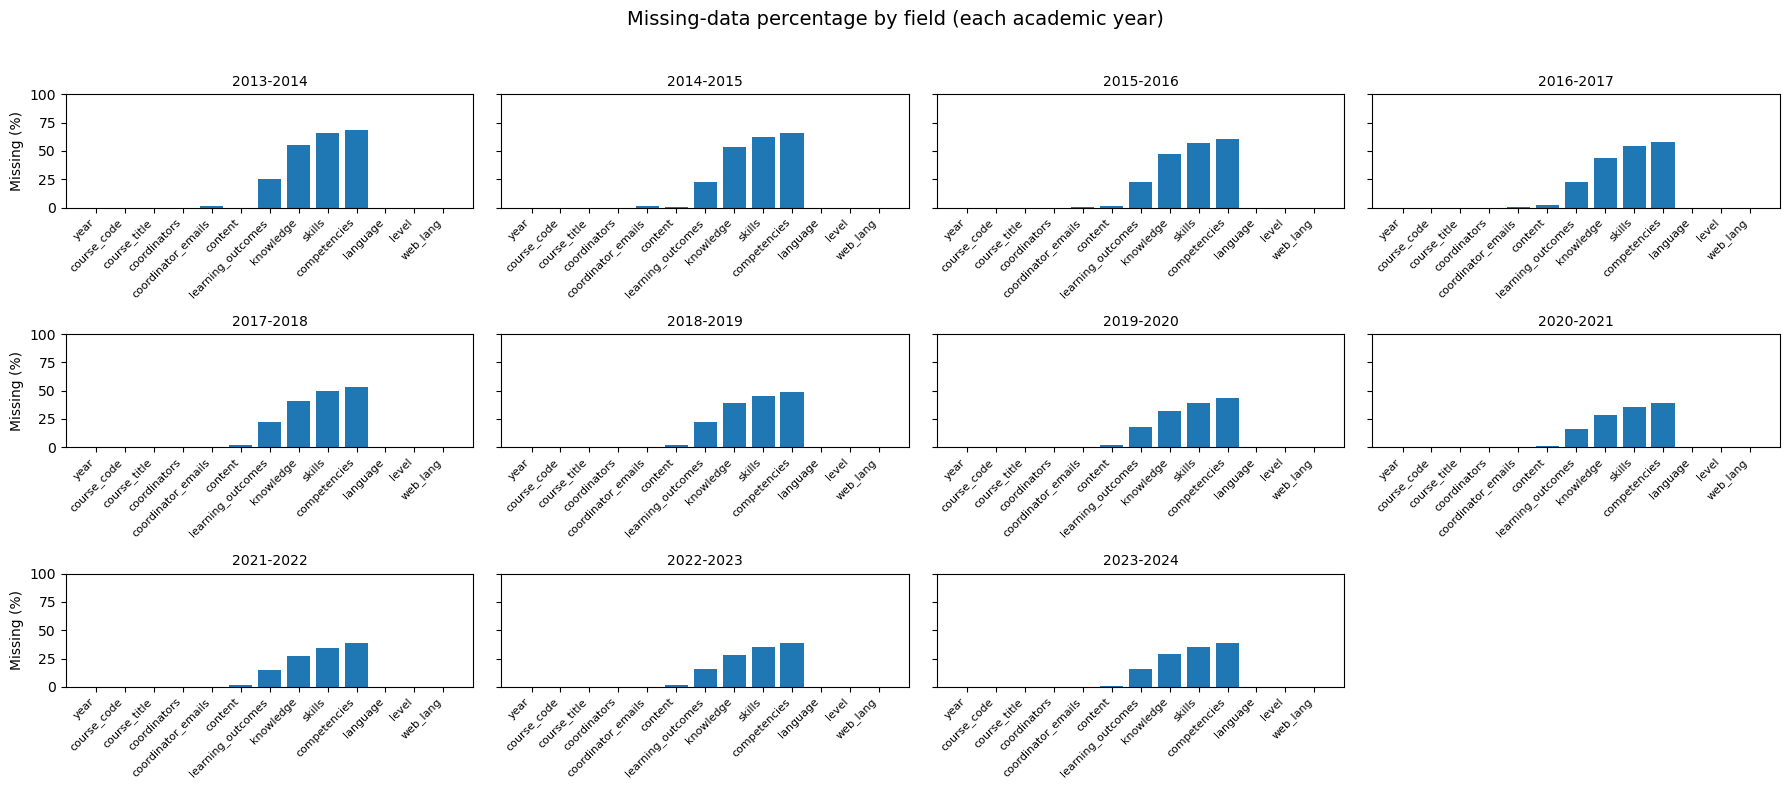

In [ ]:
# Plot missing-data percentages by field for each academic year
nrows, ncols = 3, 4

# Produce a grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8), sharey=True)
axes = axes.flatten()

# Plot each year's missing data as a bar chart
for idx, yr in enumerate(years):
    ax = axes[idx]
    yvals = [pct_missing[yr][fld] for fld in FIELDS]
    ax.bar(range(len(FIELDS)), yvals)
    ax.set_title(yr, fontsize=10)
    ax.set_xticks(range(len(FIELDS)))
    ax.set_xticklabels(FIELDS, rotation=45, ha="right", fontsize=8)
    ax.set_ylim(0, 100)
    if idx % ncols == 0:
        ax.set_ylabel("Missing (%)")

# Hide unused axes if <10 years
for ax in axes[len(years):]:
    ax.axis("off")

# Add a super title and adjust layout
fig.suptitle("Missing-data percentage by field (each academic year)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

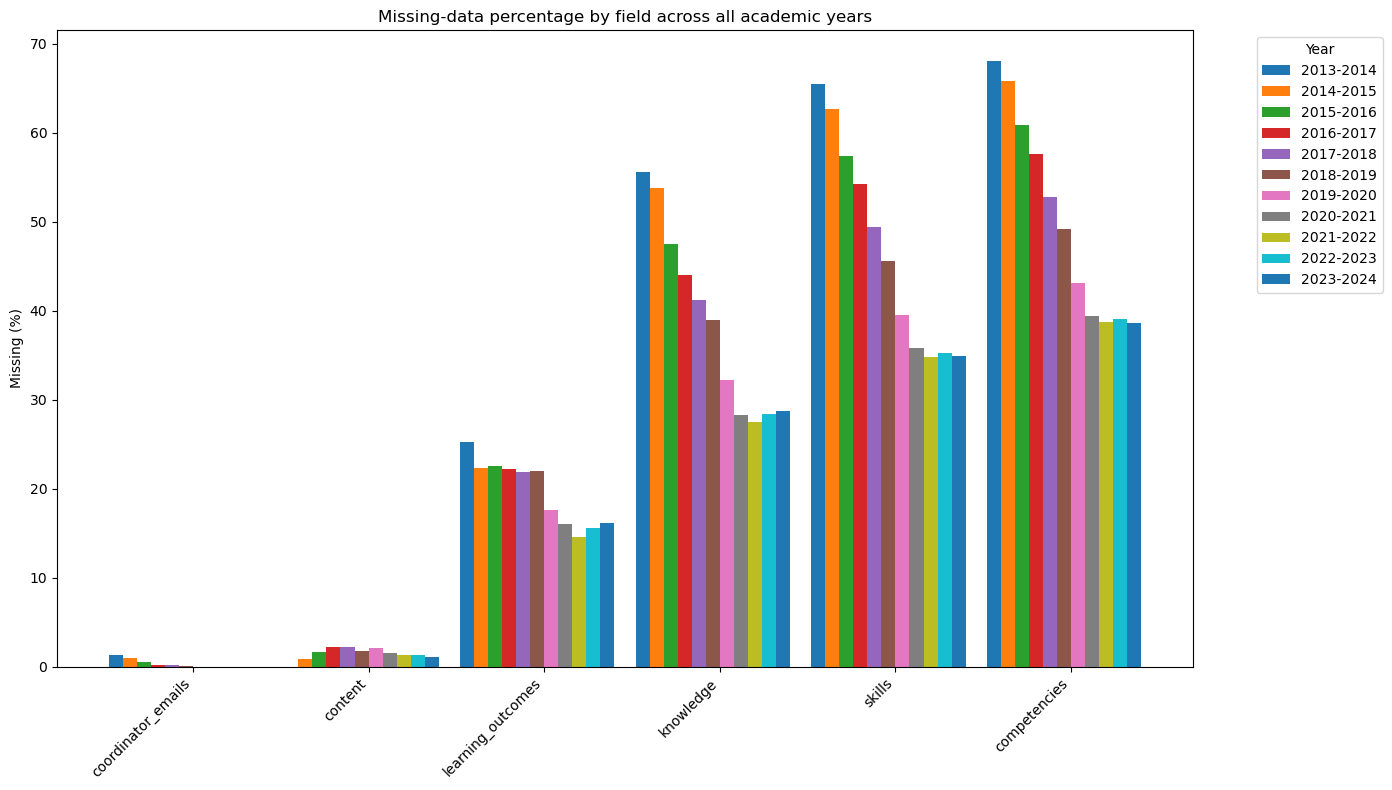

In [ ]:
# Create a grouped bar chart for missing data percentages across all years
bar_width = 0.08  # Width of each bar

# Filter fields with missing data > 0 for any year
fields_with_missing = [
    fld for fld in FIELDS if any(pct_missing[yr][fld] > 0 for yr in years)
]
x_indices = np.arange(len(fields_with_missing))  # X positions for filtered fields

plt.figure(figsize=(14, 8))

# Plot bars for each year
for i, yr in enumerate(years):
    yvals = [pct_missing[yr][fld] for fld in fields_with_missing]
    plt.bar(x_indices + i * bar_width, yvals, bar_width, label=yr)

# Add labels and formatting
plt.xticks(x_indices + (len(years) * bar_width) / 2, fields_with_missing, rotation=45, ha="right")
plt.ylabel("Missing (%)")
plt.title("Missing-data percentage by field across all academic years")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Graph 3: Average character length of text fields over time


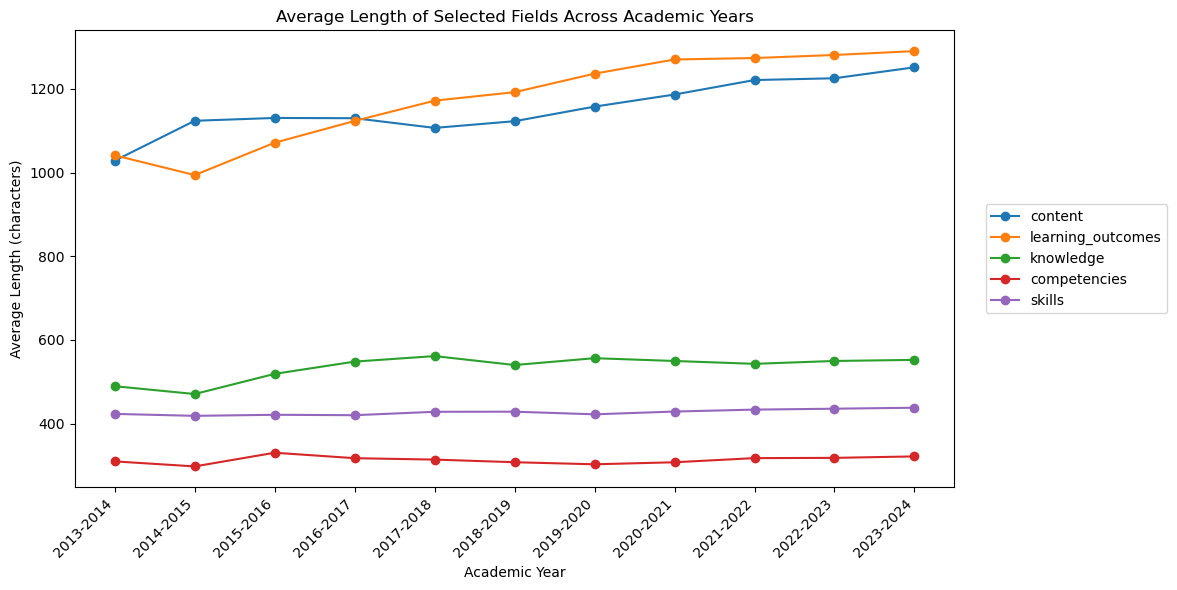

In [ ]:
# Plot average lengths of specified fields across years
plt.figure(figsize=(12, 6))
fields_to_plot = ['content', 'learning_outcomes', 'knowledge', 'competencies', 'skills']

# Calculate average length of fields across years (ignoring missing fields)
avg_lengths_by_year = {yr: {fld: [] for fld in FIELDS} for yr in years}
for rec in records:
    yr = rec.get("year")
    if yr in avg_lengths_by_year:
        for fld in FIELDS:
            if fld == "year":  # Skip 'year' field
                continue
            value = rec.get(fld)
            if isinstance(value, str) and value.strip():
                avg_lengths_by_year[yr][fld].append(len(value))
            elif isinstance(value, (list, tuple)) and value:
                avg_lengths_by_year[yr][fld].append(sum(len(str(v)) for v in value) / len(value))
            else:
                continue

# Calculate average length by year
avg_by_year = {
    yr: {fld: np.mean(avg_lengths_by_year[yr][fld]) if avg_lengths_by_year[yr][fld] else 0 for fld in FIELDS if fld != "year"}
    for yr in years
}

for fld in fields_to_plot:
    yvals = [avg_by_year[yr][fld] for yr in years]
    plt.plot(years, yvals, marker='o', label=fld)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Academic Year")
plt.ylabel("Average Length (characters)")
plt.title("Average Length of Selected Fields Across Academic Years")
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))  # Move legend to center-right
plt.tight_layout()
plt.show()

Table 4: Proportion of files without valid emails

In [ ]:
import json

PATH = "web_scraping/courses_2013-2014_all_boards.json"

with open(PATH, "r", encoding="utf-8") as f:
    courses = json.load(f)

non_null_emails = sum(
    1 for c in courses
    for e in (c.get("clean_coordinator_emails") or [])
    if e is not None and str(e).strip() != ""
)

print("Populated (non-null) emails:", non_null_emails)

def has_email(c):
    return any(e and str(e).strip() for e in (c.get("coordinator_emails") or []))

total = len(courses)
with_none = sum(1 for c in courses if not has_email(c))

print("Courses with NO emails:", with_none, f"out of {total}")

# Total number of courses
print("Total courses:", total)